# Web Parsing


## Introduction to Web Parsing

Web Parsing has 4 main steps

1. Create the URL that correspond to a search or a page you want
2. Get the content of the HTML page based on the URL
3. Parsing the content of the HTML page to retrieve the data you want
4. Storing / Processing this data

And about these steps:
* #1 is quite easy
* #2 could be complex if the page is protected by password or a mechanism to prevent web scrapping
* #3 is OK but you need to understand a bit about HTML
* #4 is just Python stuff

### Interactive Learning

A fun and interactive way to learn has been created here:

https://quizizz.com/join/lesson/621b9031fbcbe9001d6b30c2/start

This refers to the two following links introducing respectively HTML and Web Parsing:
* https://www.w3schools.com/html/html_intro.asp
* https://medium.com/opex-analytics/simple-web-scraping-in-python-90d6fddfaeca



### Example of simple Web Parsing

In this introduction, we will try to extract product names and prices from this website:
http://automationpractice.com/index.php

*NOTE: this is a dummy merchant website created to practice Web Test Automation and Web Scrapping.*

In [1]:
import requests

from bs4 import BeautifulSoup

url = "http://automationpractice.com/index.php"

# makes a request to the web page and gets its HTML
r = requests.get(url)

# stores the HTML page in 'soup', a BeautifulSoup object
soup = BeautifulSoup(r.content)


We can show the content stored in the "soup" with `soup.prettify()`

In [2]:
print(soup.prettify())

<!DOCTYPE HTML>
<!--[if lt IE 7]> <html class="no-js lt-ie9 lt-ie8 lt-ie7 " lang="en"><![endif]-->
<!--[if IE 7]><html class="no-js lt-ie9 lt-ie8 ie7" lang="en"><![endif]-->
<!--[if IE 8]><html class="no-js lt-ie9 ie8" lang="en"><![endif]-->
<!--[if gt IE 8]> <html class="no-js ie9" lang="en"><![endif]-->
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   My Store
  </title>
  <meta content="Shop powered by PrestaShop" name="description"/>
  <meta content="PrestaShop" name="generator"/>
  <meta content="index,follow" name="robots"/>
  <meta content="width=device-width, minimum-scale=0.25, maximum-scale=1.6, initial-scale=1.0" name="viewport"/>
  <meta content="yes" name="apple-mobile-web-app-capable"/>
  <link href="/img/favicon.ico?1461205423" rel="icon" type="image/vnd.microsoft.icon"/>
  <link href="/img/favicon.ico?1461205423" rel="shortcut icon" type="image/x-icon"/>
  <link href="/themes/default-bootstrap/css/global.css" media="all" rel="stylesheet" type="text/css"/>

In [3]:
list_products = {}

for product in soup.find_all("div", class_="product-container"):
    name = product.find("a", class_="product-name").text.strip()
    price = product.find("span", class_="price").text.strip()
    list_products[name] = price

list_products

{'Faded Short Sleeve T-shirts': '$16.51',
 'Blouse': '$27.00',
 'Printed Dress': '$50.99',
 'Printed Summer Dress': '$30.50',
 'Printed Chiffon Dress': '$16.40'}

... BUT we only get 5 products because some products have the same name: so it's better to store all data in a list of Tuples for example

In [4]:
list_products_tuples = []

for product in soup.find_all("div", class_="product-container"):
    name = product.find("a", class_="product-name").text.strip()
    price = product.find("span", class_="price").text.strip()
    list_products_tuples.append((name, price))  # double parentheses here because we need a tuple

list_products_tuples

[('Faded Short Sleeve T-shirts', '$16.51'),
 ('Blouse', '$27.00'),
 ('Printed Dress', '$26.00'),
 ('Printed Dress', '$50.99'),
 ('Printed Summer Dress', '$28.98'),
 ('Printed Summer Dress', '$30.50'),
 ('Printed Chiffon Dress', '$16.40'),
 ('Printed Chiffon Dress', '$16.40'),
 ('Faded Short Sleeve T-shirts', '$16.51'),
 ('Blouse', '$27.00'),
 ('Printed Summer Dress', '$28.98'),
 ('Printed Dress', '$26.00'),
 ('Printed Summer Dress', '$30.50'),
 ('Printed Dress', '$50.99')]

Usually we will use `pandas`, which is THE library for data science.

The data is stored in a `DataFrame`, which is the equivalent of an Excel Table.
The usual way to create a Data Frame is:
* from an Excel or .csv file if we have one
* from a list of tuples, that will correspond to the values in columns
* from a list of dictionaries, that will create the needed columns and their headers

Here, we could use a list of tuples we just created.

In [5]:
import pandas as pd

df = pd.DataFrame(list_products_tuples, columns=["Product", "Price"])
df

,Product,Price
0,Faded Short Sleeve T-shirts,$16.51
1,Blouse,$27.00
2,Printed Dress,$26.00
3,Printed Dress,$50.99
4,Printed Summer Dress,$28.98
5,Printed Summer Dress,$30.50
6,Printed Chiffon Dress,$16.40
7,Printed Chiffon Dress,$16.40
8,Faded Short Sleeve T-shirts,$16.51
9,Blouse,$27.00


Or we could use a list of dictionaries with 2 keys:
* `"Product"`
* `"Price"`

NOTE: we need to remove the `$` from the price and convert to a float!

... and why not using list Comprehension :)

In [22]:
import pandas as pd

list_products_dict = [
    {
        "Product": p.find("a", class_="product-name").text.strip(),
        "Price": float(p.find("span", class_="price").text.strip().strip("$")),
    }
    for p in soup.find_all("div", class_="product-container")
]
df = pd.DataFrame(list_products_dict)
df


,Product,Price
0,Faded Short Sleeve T-shirts,16.51
1,Blouse,27.00
2,Printed Dress,26.00
3,Printed Dress,50.99
4,Printed Summer Dress,28.98
5,Printed Summer Dress,30.50
6,Printed Chiffon Dress,16.40
7,Printed Chiffon Dress,16.40
8,Faded Short Sleeve T-shirts,16.51
9,Blouse,27.00


We can check the type of data with `.dtypes`, to verify that prices are floats.

In [23]:
df.dtypes

Product     object
Price      float64
dtype: object

... so now we can draw some graph, get the average, maximum, ...

In [24]:
df.describe()

,Price
count,14.000000
mean,28.054286
std,11.144574
min,16.400000
25%,18.882500
50%,27.000000
75%,30.120000
max,50.990000


<AxesSubplot:ylabel='Frequency'>

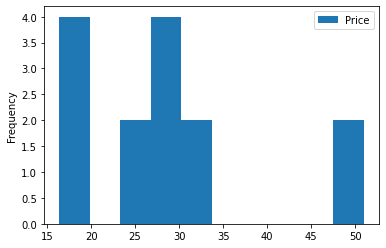

In [25]:
df.plot.hist()

# ... it seems there is a bug with the labels of the axes which are missing

## Project - Part 1: WEB SCRAPPING OF PRODUCTS

We will create a small web parsing project that will retrieve prices from different merchant websites.

